<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# TalkingData Kaggle: Feature Engineering

***

### About the competition:

The risk of fraud exists everywhere, but companies that 
offer advertisements online are especially at risk for click fraud. Click fraud occurs
online in a pay-per-click scheme where owners of websites that post ads are paid a small 
amount every time a visitor to their website clicks on an ad. Malicious entities exist 
that are willing to employ computer scripts and/or low wage workers to intentionally generate 
money for the owners of the websites and costs for the advertisers. This results in misleading 
click data and wasted money for advertisers.

TalkingData is China's largest independent big data service platform and covers over 70% 
of active mobile devices in China, generating 3 billion clicks every day of which many are sources of potential click fraud. App developers pay money to advertisers to advertise their specific app in which some potential customers who click on the ad download the app and some do not. However some hostile actors exist who 
are willing to repeatedly click on the ads and never download the app, constituting in some cases click fraud or maybe a highly hesitant customer.

### How does TalkingData currently deal with click fraud?

Currently TalkingData handles probable click fraud cases for app developers by measuring the journey 
of a user's click across their portfolio and flagging IPs which produce many clicks but never download apps.

Now they have turned to the Kaggle community to build an algorithm that predicts if a user will download an app after clicking a mobile app ad. (https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection).

## Data and Problem

***

Objective: In this competition the objective is to use the properties of clicks on mobile ads to predict if a click will result in the download of the app that was advertised. 

TalkingData has provided a huge dataset gathered over 4 days featuring over 203 million rows. Specifically the training set contains about 185 million labelled samples and the test set contains nearly 19 million unlabelled samples.

__Data Fields:__ 
  -  __ip__: ip address of click 
  -  __app__: app id for marketing 
  -  __device__: device type id of user mobile phone 
  -  __os__: os version id of user mobile phone 
  -  __channel__: channel id of mobile ad publisher 
  -  __click_time__: timestamp of click (UTC)
  -  __attributed_time__: if user downloaded the app, this is the time of the app download (UTC)
  -  __is_attributed__: target to predict, indicating the app was downloaded (target we are trying to predict, only present in train)
  
The features ip, app, device, os and channel are all categorical variables, click_time and attributed_time are time variables and is_attributed is the target which we want to predict.

Note: ip, app, device, os, channel are all encoded (identity hidden) this hampers feature creation since domain specific knowledge is not applicable to these variates. 

The test data is similar, with attributed_time and is_attributed removed, also click_id is an added data field to the test set which is a reference for making predictions.

This competition is a __binary classification__ problem. We are attempting to categorize clicks into 2 categories:

  - class 0: app was not downloaded after mobile app ad click (negative class)
  - class 1: app was downloaded after mobile app ad click (positive class)
    
The metric of evaluation is [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). This is a standard metric used to determine how well a model will predict for a certain class, in this case class 1, otherwise known as the positive class. Binary classification leads to 2 ways of being right and 2 ways of being wrong:

-  __False Positive__: Positive class was predicted incorrectly
-  False Negative: Negative class was predicted incorrectly
-  __True Positive__: Positive class was predicted correctly
-  True Negative: Negative class was predicted correctly

ROC creates a curve by plotting the true positive rate vs the false positive rate at various threshold settings. Thus it intristically measures how well we are actually predicting the positive class vs how badly we are predicting the positive class. In the context of this competition it will be measuring how well we are predicting the app being downloaded after the mobile advertisement for it was clicked.

Therefore it will be of utmost important to specifically understand the target we are trying to predict.
  
It is also impervious to note that the leaderboard is calculated with only 18% of the test data. Therefore it is more than likely that high performing models are overfitting the small test set (eg: over tuning parameters) and that intuitive and reasonable feature creation should hypothetically perform just as well computationally intensive methods. 

## Exploratory Data Analysis

***

For this analysis we will focus on 3 sets of data:
   -  Entire testing set
   -  Sample of training set (~ 10 million rows)
   -  Entire training set where click resulted in download (is_attributed == 1)
   
The training dataset is around ~7 GB large which makes dealing with the entire set impossible on my machine. Therefore we are forced to make due with a smaller sample of the training data. Fortunately other kaggle kernels feature analyses using the entire train set and reach similar conclusions to the ones below.

Import libraries and data:

In [10]:
import gc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Load entire test set
test = pd.read_csv('test.csv', parse_dates=['click_time'])
# Load sample of train set, (due to memory constrains entire set is too large to handle in memory on my machine)
train = pd.read_csv('train.csv', nrows=10000000, parse_dates=['click_time'])
# Load entire traing set, this set was created before the notebook
train_target_1 = pd.read_csv('class1.csv', parse_dates=['click_time'])
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


## Target:

This is the variable which we are trying to predict for. It's important to know the distribution of the classes.

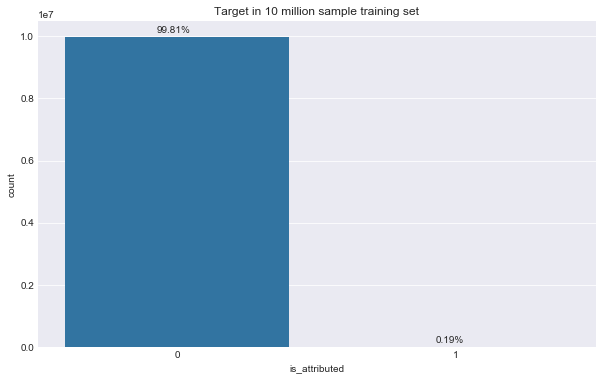

In [9]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plt.title("Target in 10 million sample training set")
ax = sns.countplot(x="is_attributed", data=train)
for p in ax.patches:
        ax.annotate("{0:.02f}%".format(100*p.get_height()/len(train)), (p.get_x()+0.325, p.get_height()+120000))

__Conclusion__: Extremely high class imbalance, we need to make sure this property is held when training and validating our models. The real class imbalance is ~0.247% compared to our graphic which is ~0.19%.

## Number of unique values per feature:

Here we take a look at how many unique features our categorical variates have. This is important as it will influence feature creation.

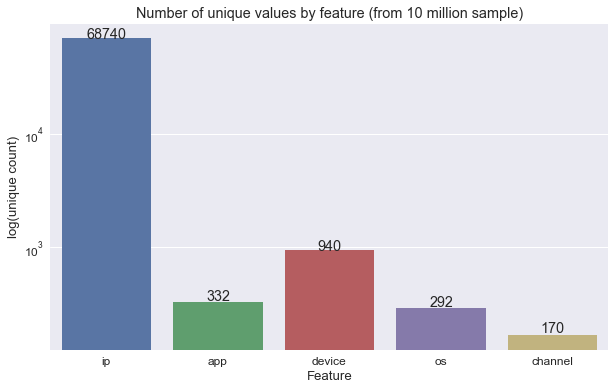

In [12]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values by feature (from 10 million sample)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

__Conclusion__: With only ~5% of the training data we observe a high amount of unique features among the categorical variates of the test data. This means we must find other methods of dealing with this data than one-hot-encoding each category in each variate.

## Histogram of ip adresses:

Distribution of the ip adresses where the click was generated

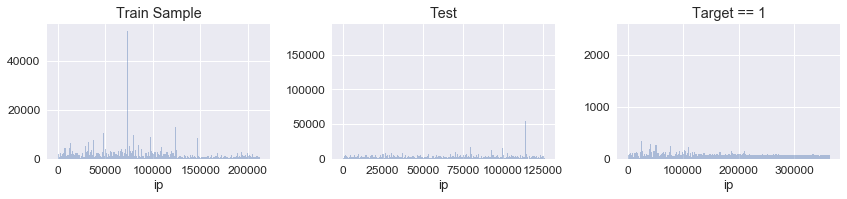

In [31]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["ip"], kde = False, bins = 5000)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["ip"], kde = False, bins = 5000)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["ip"], kde = False, bins = 5000)
plt.tight_layout()

__Conclusion:__ Train and Test seem different. The target seems to be evenly distrubted among the ips, not much inference generated from these visualizations.

## Histogram of app that was advertised

Distribution of app that was being advertised:

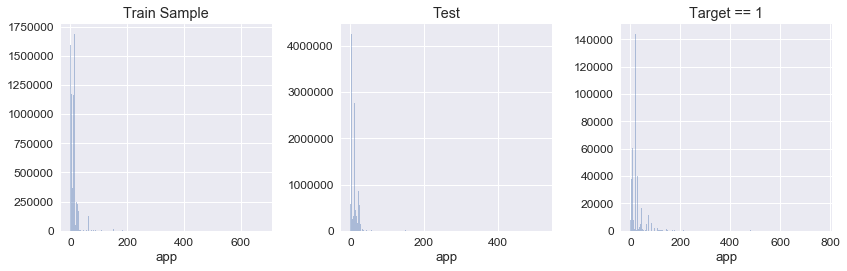

In [32]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["app"], kde = False, bins = 300)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["app"], kde = False, bins = 300)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["app"], kde = False, bins = 300)
plt.tight_layout()

__Conclusion:__ A small amount of the apps make up most of the clicks. It also looks like the test and train samples are in relative agreement.

## Histogram of device used to click on advertisement

Distribution of the device that the click was generated from:

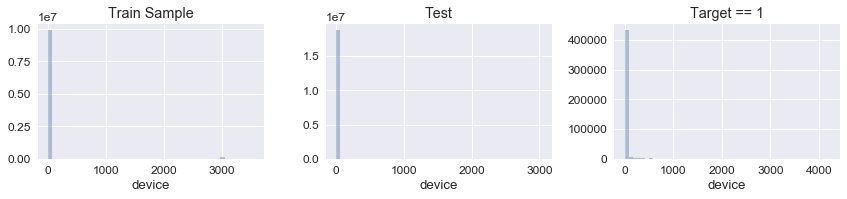

In [38]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["device"], kde = False, bins = 50)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["device"], kde = False, bins = 50)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["device"], kde = False, bins = 50)
plt.tight_layout()

__Conclusion:__ All of the clicks are coming from a very small set of devices

## Histogram of operating system 

Distribution of operating system that generated the click:

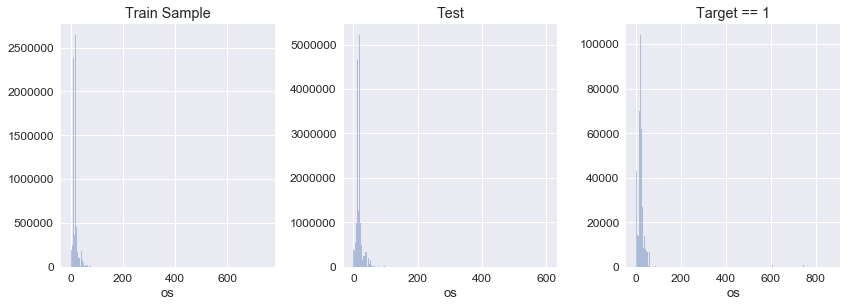

In [39]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,4.5))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["os"], kde = False, bins = 280)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["os"], kde = False, bins = 280)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["os"], kde = False, bins = 280)
plt.tight_layout()

__Conclusion:__ The operating system among the train and test sets are in agreement and the target seems to be in relative agreement as well.

## Histogram of channel

Distribution of the publisher of the advertisement:

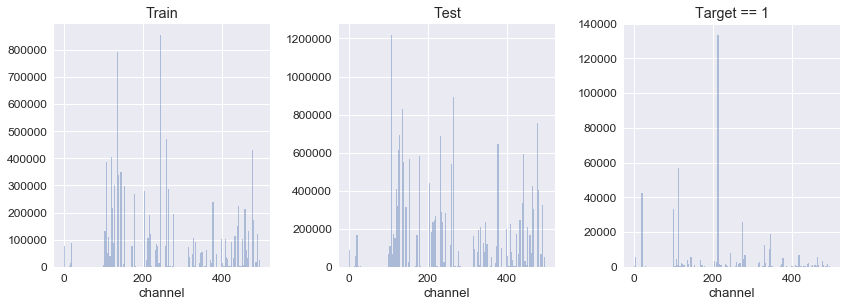

In [20]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,4.5))
plt.subplot(1,3,1)
plt.title("Train")
sns.distplot(train["channel"], kde = False, bins = 160)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["channel"], kde = False, bins = 160)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["channel"], kde = False, bins = 160)
plt.tight_layout()

__Conclusion:__ Training and testing set seem to be relatively similar. Our target is much more stratified.

## Visualizing the time of the click

We first need to extract the time variables from the data. One problem these visualizations miss is that all the clicks are in time order from oldest to newest, and the method which we gathered the instances just grabbed the first 10 million rows.

In [40]:
train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')
test['day'] = test['click_time'].dt.day.astype('uint8')
test['hour'] = test['click_time'].dt.hour.astype('uint8')
test['minute'] = test['click_time'].dt.minute.astype('uint8')
test['second'] = test['click_time'].dt.second.astype('uint8')
train_target_1['day'] = train_target_1['click_time'].dt.day.astype('uint8')
train_target_1['hour'] = train_target_1['click_time'].dt.hour.astype('uint8')
train_target_1['minute'] = train_target_1['click_time'].dt.minute.astype('uint8')
train_target_1['second'] = train_target_1['click_time'].dt.second.astype('uint8')

## Hour of Click

Distribution of the hour when click happened

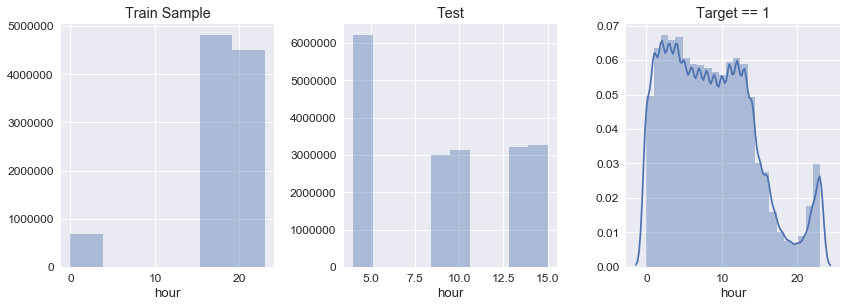

In [42]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,4.5))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["hour"], kde = False, bins = 6)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["hour"], kde = False, bins = 10)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["hour"], bins = 24)
plt.tight_layout()

__Note__: Test oddly only contains observations from certain hours, the train sample is biased due to grabbing the first 10 million rows. The plot for the target reflects something more reasonable.

## Minute of Click

Distribution of the minute the click was generated:

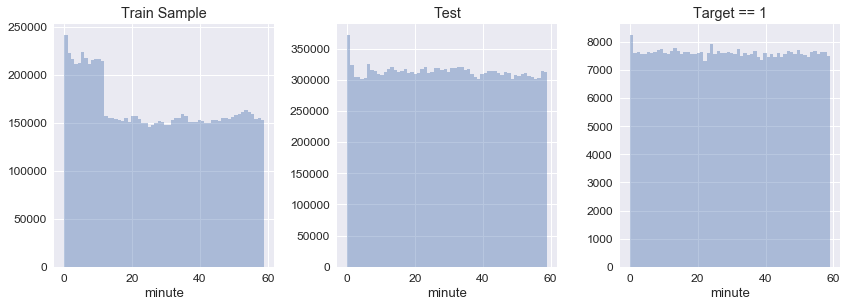

In [44]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,4.5))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["minute"], kde = False, bins = 60)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["minute"], kde = False, bins = 60)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["minute"], kde = False, bins = 60)
plt.tight_layout()

__Conclusion__: Training set is again biased due to grabbing the first 10 million rows. We note that there seem to be much more clicks at the start of the hour (minute == 0). This is reflected in the target as well.

## Second of Click

Distribution of the second when the click was generated

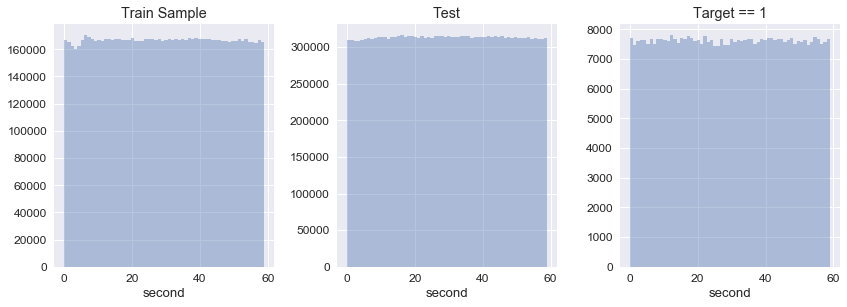

In [47]:
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
plt.figure(figsize=(12,4.5))
plt.subplot(1,3,1)
plt.title("Train Sample")
sns.distplot(train["second"], kde = False, bins = 60)
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Test")
sns.distplot(test["second"], kde = False, bins = 60)
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Target == 1")
sns.distplot(train_target_1["second"], kde = False, bins = 60)
plt.tight_layout()

__Conclusions__: Nothing of note was gathered here.

## EDA Conclusions: 

***

   -  The problem features a high class imbalance property only ~0.247% of the clicks generate a download. 
   -  App, os, ip, device and channel are all unordered categorical variates and feature an inordinate amount of unique values. One-hot-encoding is a inappropriate method to deal with categorical data with high cardinality.
   
__Cardinality__: The number of elements in a set

In the next section we will take the base features TalkingData has given us and turn them into new features that can hopefully be used to predict our target.



## Feature Creation:

***

## Frequency features: 

Do some ips, apps, devices, operating systems or ad channels have a higher frequency of download? In the following method we try to extract this information from the data. We wish to calculate the following for combinations of categories.

$$P( \ is\_attributed \ | \ category \ )$$

Where category can be a mixture of categories for any click.

The inherrent problem here is that due to the high cardinality of our categorical data we will often find that some combinations are not represented often in the data. Therefore if one of those clicks result in a download than that category combination will have an overrepresented bayesian probability. Thus we suggest a method of re-weighting the probability:

$$weight = \frac{log( \ count \ of \ category \ ) }{ log(100000)}$$

Thus our new bayesian probability is:

$$min(1 \ ,  weight)*P( \ is\_attributed \ | \ category \ )$$

We take the minimum here since we want the probability to still lie within 0 to 1. Below we create the features, we examine a set of single, double and triple interaction features, more than triple features are not taken into account as to not 

In [49]:
train = pd.read_csv('train.csv', nrows=1000000, parse_dates=['click_time'])
train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

ATTRIBUTION_CATEGORIES = [ 
    # single interaction
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # double interaction
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device'],
    
    # triple interaction
    ['channel', 'os', 'ip'],
    ['channel', 'device', 'os'],
    ['os', 'device', 'app']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    train = train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 6437 / 25.25 / 10.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 141851 / 4672.9 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 938053 / 3355.7 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 239642 / 6250.0 / 38.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 92534 / 6493.51 / 1200.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 61413 / 1915.71 / 18.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Min: 3485

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate,channel_os_ip_confRate,channel_device_os_confRate,os_device_app_confRate
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182,0.0,0.000000,0.000321
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,0.000497,0.000360,0.000275,0.000444,0.000235,0.000499,0.001428,0.0,0.000235,0.000280
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182,0.0,0.000000,0.000321
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,0.004071,0.004164,0.000201,0.000445,0.001835,0.004109,0.001182,0.0,0.001869,0.000205
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182,0.0,0.000000,0.000321


## Aggregation Features: 

Here we create more features based on simple aggregation features. These include: counts, means, variances.

We can create: 
-  variance in some time amount for combination of categories
-  counts for combinations of categories
-  means for combinations of categories
-  other similar aggregations


In [50]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    

    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        train[new_feature] = gp[0].values
    else:
        train = train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

train.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nu

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os,ip_nunique_device,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,19,2,5,1,34,16,0,0,0,1.333333
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,20,3,8,1,34,11,0,0,0,1.000000
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,17,2,6,3,34,10,0,0,0,2.000000
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,31,2,18,6,26,24,0,0,0,1.000000
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,1,1,1,1,34,1,0,0,0,NaN


## Time features: 

Here we create features based on time until next click (eg: how long it takes given some categorical combination (like ip-app-device) before another click comes from that combination?).

In [51]:
GROUP_BY_NEXT_CLICKS = [
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    train[new_feature] = train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to next click in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to next click in: ip_os_device_app_nextClick


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,0,0,1.333333,5290.0,5340.0,5444.0,5307.0,NaN,5307.0,5340.0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,0,0,1.000000,5177.0,5177.0,5177.0,5239.0,NaN,5239.0,5547.0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,0,0,2.000000,5175.0,5175.0,6005.0,5205.0,NaN,5205.0,5925.0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,0,0,1.000000,5108.0,5110.0,5137.0,5108.0,NaN,5108.0,5110.0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Evaluating Feature Importance:

How do we determine if the features we created are actually worth anything? In this notebook we will choose to use extreme gradient boosting, otherwise known as XGBoost to test out our features:

__Why XGBoost?__: It wins lots of kaggle competitions. It's relatively simple to understand and highly powerful. A wealth of information exists for this type of model in the form of kernels and on the internet in general. It is one of the premier algorithms used for datascience on kaggle.

__Intro to XGBoost__: XGBoost is a supervised machine learning method where we have labelled training data and target variables to predict. Different problems call for different metrics to evaluate on. We have an objective function for which we measure the performance of a model. This objective contains a training loss and a regularization term. The training loss evaluates how our model performed and the regularization controls complexity. 

XGBoost is a tree ensemble method that follows CART (classification and regression trees). A simple explanation of cart follows. Imagine you create a graph like binary tree structure and at each node you want to make a binary evaluation (to move down an edge). You start at the parent node and you make a binary decision. This binary decision is either regression based (eg: is your age over 24?) or classification based (eg: are you male?). So at the parent node you answer yes or no and go down that specific edge slowly making your way to the end of the tree structure. And once the end is reached a prediction score is assigned to each leaf. This is one tree. 

I won't be covering the exact specifics of the algorithm in this notebook. If you would like to read more about it there are a wealth of websites covering the topic. 

__Conclusion__: We can use this computationally intensive model to determine the predictive yield of the features that were created earlier in this notebook.

In [79]:
import xgboost as xgb

# Split into X and y
y = train['is_attributed']
X = train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic',
    eval_metric = 'auc'
)
# Fit the models
print("starting training:")
clf_xgBoost.fit(X, y)

starting training:


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=0, missing=None,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=4,
       reg_lambda=1, scale_pos_weight=9, seed=None, silent=True,
       subsample=0.8)

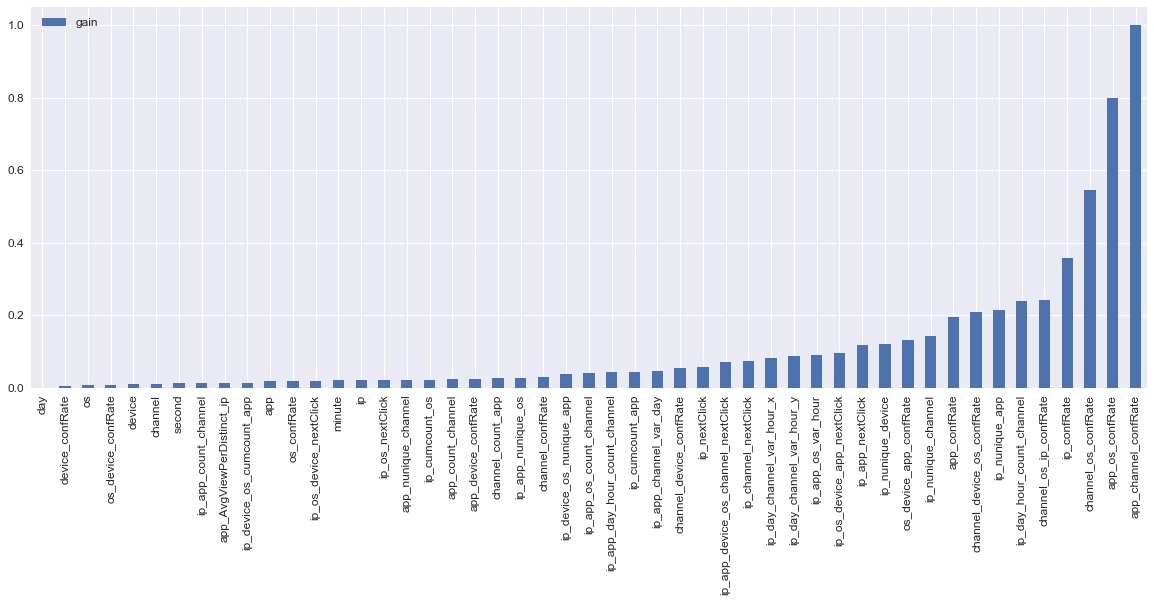

In [80]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
importance_dict['gain'] = clf_xgBoost.get_booster().get_score(importance_type='gain')
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Plot the feature importances
importance_df.sort_values('gain').plot(kind='bar', figsize=(20, 7))
plt.bar(importance_df.sort_values('gain'), height, color=(0.2, 0.4, 0.6, 0.6))

There exist many methods to determine feature importance online. However importance is a rather ambiguous term and its important we create some metric to determine how "important" a feature is. 

In this notebook we will use gain as our standard for feature importance. Gain is the average training loss reduction gained when using a feature for splitting in the tree. 

As we can see from the plot over 50 % of the features created yielded better training results than the base features. In this case 34 of our features perform better than the best performing base feature ip. On that note, some features perform extradorinarily compared to the others. Those best performing features are all results of our frequency approach.

__Conclusion__: We have created meaningful features from the data

# Summary:

In this notebook we:

  -  Introduced the TalkingData Click Fraud Kaggle Competition
  -  Summarized the data and the problem
  -  Completed a thorough EDA on the data
  -  Explored methods to extract features from high cardinality data
  -  Trained a preliminary model to determine whether engineered features created significant predictive power
  -  Proved that the features that were created produce a valuable amount of predictive power